In [1]:
import sys
from pathlib import Path

In [2]:
PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

In [3]:
from pinecone import Pinecone
from langchain_pinecone import PineconeVectorStore
from langchain_community.embeddings import OllamaEmbeddings
from graph import EpilepsyState
from llms.groq_llm import get_groq_llm

/home/aasritha/EpilepsyNexus/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from config import PINECONE_API_KEY

In [5]:
prompt_path = PROJECT_ROOT / "prompts" / "medical_rag_prompt.txt"

with open(prompt_path, "r", encoding="utf-8") as f:
    template_text = f.read()

In [6]:
from langchain_core.prompts import PromptTemplate

In [7]:
prompt = PromptTemplate(
    template=template_text,
    input_variables=[
        "context",
        "epilepsy_presence",
        "seizure_phase",
        "seizure_type",
        "fusion_explanation",
    ],
)

In [8]:
INDEX_NAME = "epilepsynexus"

In [9]:
pc = Pinecone(api_key=PINECONE_API_KEY)

In [10]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_pinecone import PineconeVectorStore

embedding_model = HuggingFaceEmbeddings(
    model_name="BAAI/bge-large-en-v1.5",
    encode_kwargs={"normalize_embeddings": True}
)


/tmp/ipykernel_39941/2326114763.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(
Loading weights: 100%|██████████| 391/391 [00:00<00:00, 568.25it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: BAAI/bge-large-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [11]:
vectorstore = PineconeVectorStore(
    index_name=INDEX_NAME,
    embedding=embedding_model,
)

retriever = vectorstore.as_retriever(search_kwargs={"k": 4})


In [12]:
llm = get_groq_llm()

In [13]:
def medical_rag_node(state: EpilepsyState) -> EpilepsyState:
    """
    Retrieves epilepsy knowledge and enriches model outputs.
    """

    # Build retrieval query
    query = f"""
    Epilepsy Presence: {state.epilepsy_presence}
    Seizure Phase: {state.seizure_phase}
    Seizure Type: {state.seizure_type}
    """

    # Retrieve documents from Pinecone
    docs = retriever.invoke(query)

    context = "\n\n".join([doc.page_content for doc in docs])

    # Run Groq LLM
    response = llm.invoke(
        prompt.format(
            context=context,
            epilepsy_presence=state.epilepsy_presence,
            seizure_phase=state.seizure_phase,
            seizure_type=state.seizure_type,
            fusion_explanation=state.fusion_explanation,
        )
    )

    # Store in state
    state.medical_context = response.content

    return state

In [14]:
if __name__ == "__main__":
    test_state = EpilepsyState(
        epilepsy_presence="yes",
        seizure_phase="ictal",
        seizure_type="focal",
        fusion_explanation="MRI abnormalities correlate with focal EEG findings.",
    )

    result = medical_rag_node(test_state)
    print(result.medical_context)


**Background on Epilepsy**  
- Epilepsy is a neurological condition characterized by a propensity to generate recurrent seizures.  
- The 2017 International League Against Epilepsy (ILAE) classification distinguishes seizures by their onset and awareness. An aura, when present, is now termed a **focal aware seizure**.  
- A focal seizure may remain confined to one region of the brain, or it may spread to additional areas, potentially involving both hemispheres (formerly called a “secondarily generalized” seizure).  

**Seizure Phase Characteristics**  
- **Ictal phase** – This is the period from the beginning of the seizure (including any aura) to its termination.  
- During the ictal phase, individuals can exhibit a wide range of symptoms that vary from person to person. The retrieved context notes that the ictal stage is the portion most people recognize as “the seizure.”  

**Seizure Type Characteristics**  
- **Focal seizures** are a common seizure type in epilepsy.  
- Awareness m

Retrieval Accuracy

In [15]:
pip install pandas matplotlib seaborn tqdm

Note: you may need to restart the kernel to use updated packages.


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [17]:
def retrieval_quality(llm, query, docs):
    """
    Scores retrieval relevance using LLM.

    0 = Irrelevant
    1 = Partially relevant
    2 = Highly relevant
    """

    context = "\n\n".join([d.page_content for d in docs])

    prompt_eval = f"""
    You are a clinical neurology expert.

    Query:
    {query}

    Retrieved medical context:
    {context}

    Does this context support accurate epilepsy diagnosis and reasoning?

    Score:
    0 = Irrelevant
    1 = Partially relevant
    2 = Highly relevant

    Only return the number.
    """

    score = llm.invoke(prompt_eval).content.strip()

    try:
        return int(score)
    except:
        return 0


In [18]:
import sys
from pathlib import Path

In [19]:
PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

In [20]:
phases = ["interictal", "preictal", "ictal", "postictal", "uncertain","none"]
seizure_types = ["focal", "generalized","seizure with motor"]

In [21]:
from llms.groq_llm import get_groq_llm

In [22]:
llm = get_groq_llm()

In [23]:
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x70988ae564b0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x70988b0f3530>, model_name='openai/gpt-oss-120b', temperature=0.2, model_kwargs={}, groq_api_key=SecretStr('**********'))

In [24]:
heatmap_scores = np.zeros((len(phases), len(seizure_types)))

for i, phase in enumerate(tqdm(phases, desc="Phases")):
    for j, stype in enumerate(seizure_types):

        query = f"""
        Epilepsy Presence: yes
        Seizure Phase: {phase}
        Seizure Type: {stype}
        """

        docs = retriever.invoke(query)

        score = retrieval_quality(llm, query, docs)

        heatmap_scores[i, j] = score


Phases: 100%|██████████| 6/6 [01:14<00:00, 12.43s/it]


In [25]:
heatmap_normalized = heatmap_scores / 2.0


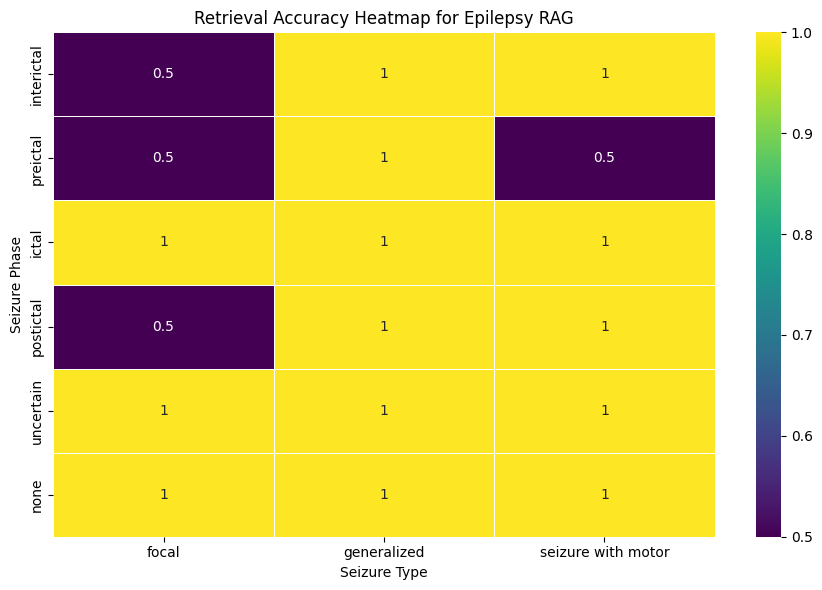

In [26]:
plt.figure(figsize=(9, 6))

sns.heatmap(
    heatmap_normalized,
    annot=True,
    cmap="viridis",
    xticklabels=seizure_types,
    yticklabels=phases,
    linewidths=0.5,
    linecolor="white"
)

plt.title("Retrieval Accuracy Heatmap for Epilepsy RAG")
plt.xlabel("Seizure Type")
plt.ylabel("Seizure Phase")
plt.tight_layout()
plt.show()


In [27]:
def llm_only_inference(llm, prompt, phase, seizure_type):
    response = llm.invoke(
        prompt.format(
            context="",
            epilepsy_presence="yes",
            seizure_phase=phase,
            seizure_type=seizure_type,
            fusion_explanation="MRI and EEG findings support this condition."
        )
    )
    return response.content


In [28]:
def rag_inference(phase, seizure_type):
    state = EpilepsyState(
        epilepsy_presence="yes",
        seizure_phase=phase,
        seizure_type=seizure_type,
        fusion_explanation="MRI and EEG findings support this condition."
    )

    result = medical_rag_node(state)
    return result.medical_context


In [29]:
def clinical_accuracy_score(llm, phase, seizure_type, output):
    eval_prompt = f"""
    You are a senior neurologist.

    Task:
    Evaluate whether the following clinical interpretation is correct and grounded
    for the given epilepsy condition.

    Seizure phase: {phase}
    Seizure type: {seizure_type}

    Model output:
    {output}

    Score:
    0 = incorrect or misleading
    1 = partially correct
    2 = clinically accurate and safe

    Only return the number.
    """

    score = llm.invoke(eval_prompt).content.strip()

    try:
        return int(score)
    except:
        return 0


In [30]:
import numpy as np
from tqdm import tqdm

llm_heatmap = np.zeros((len(phases), len(seizure_types)))
rag_heatmap = np.zeros((len(phases), len(seizure_types)))

for i, phase in enumerate(tqdm(phases, desc="Phases")):
    for j, stype in enumerate(seizure_types):

        # LLM only
        llm_output = llm_only_inference(llm, prompt, phase, stype)
        llm_score = clinical_accuracy_score(llm, phase, stype, llm_output)
        llm_heatmap[i, j] = llm_score

        # RAG
        rag_output = rag_inference(phase, stype)
        rag_score = clinical_accuracy_score(llm, phase, stype, rag_output)
        rag_heatmap[i, j] = rag_score


Phases: 100%|██████████| 6/6 [08:52<00:00, 88.68s/it]


In [31]:
llm_accuracy = llm_heatmap / 2.0
rag_accuracy = rag_heatmap / 2.0


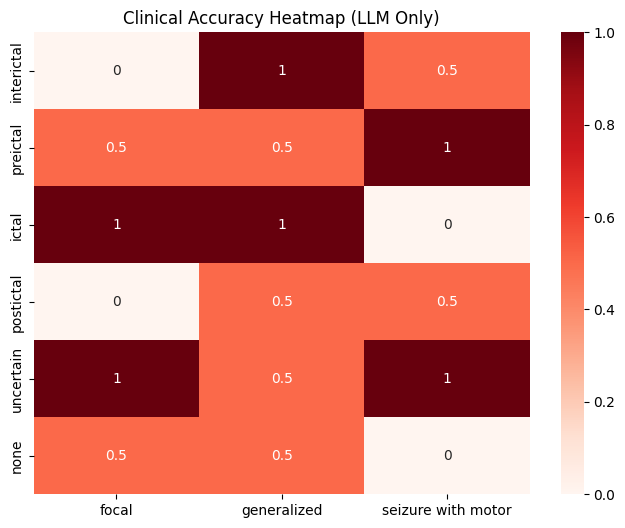

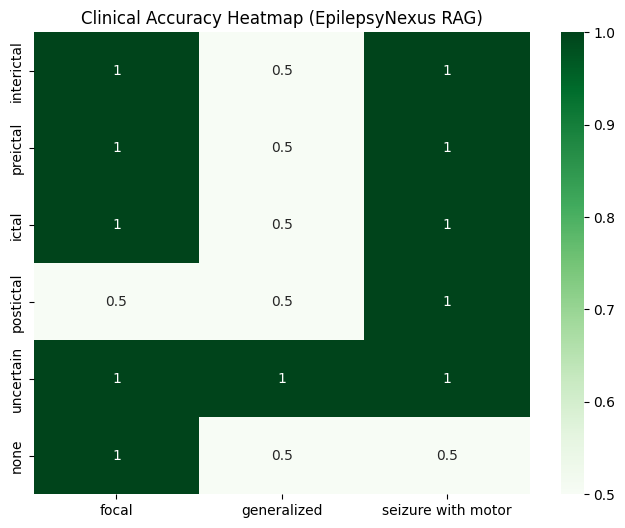

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# LLM only
plt.figure(figsize=(8,6))
sns.heatmap(
    llm_accuracy,
    annot=True,
    cmap="Reds",
    xticklabels=seizure_types,
    yticklabels=phases
)
plt.title("Clinical Accuracy Heatmap (LLM Only)")
plt.show()


# RAG
plt.figure(figsize=(8,6))
sns.heatmap(
    rag_accuracy,
    annot=True,
    cmap="Greens",
    xticklabels=seizure_types,
    yticklabels=phases
)
plt.title("Clinical Accuracy Heatmap (EpilepsyNexus RAG)")
plt.show()


In [33]:
overall_llm = llm_accuracy.mean()
overall_rag = rag_accuracy.mean()

print("Overall Clinical Accuracy")
print("LLM:", overall_llm)
print("RAG:", overall_rag)


Overall Clinical Accuracy
LLM: 0.5555555555555556
RAG: 0.8055555555555556


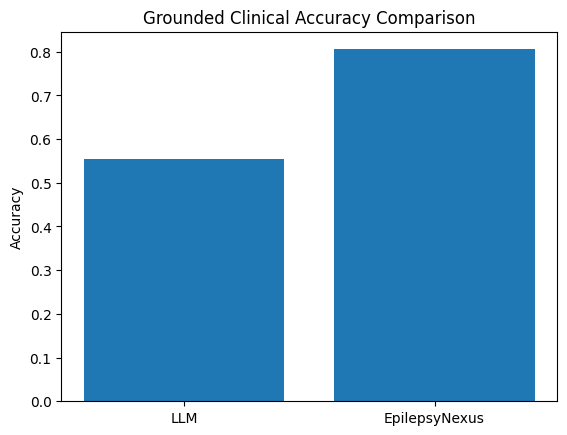

In [34]:
plt.bar(["LLM", "EpilepsyNexus"], [overall_llm, overall_rag])
plt.title("Grounded Clinical Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()
